케라스 API를 사용해 모델을 훈련하는데 필요한 다양한 도구들을 알아보고, 

이 과정에서 여러 가지 중요한 개념과 모범 사례를 살펴보자.

# 손실 곡선

keras 모델을 fit() 함수로 훈련시키면 다음과 같은 메시지가 출력되는 것을 보았는가.

<keras.callbacks.History at 0x7fe23c887c10>

fit() 함수는 History 클래스 객체를 반환한다.
- History 객체에는 훈련 과정에서 계산한 지표, 즉, 손실과 정확도 값이 저장되어 있다.
- 이 값을 사용하면 그래프를 그릴 수 있을 것 같다.

먼저 이전 장과 같이 패션 MNIST 데이터셋을 적재하고 훈련/검증 세트로 나누자.

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

4431872/4422102 [==============================] - 0s 0us/step


다음으로 모델을 만들자. 단, 이번에는 모델을 만드는 간단한 함수를 정의하자.

In [2]:
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(100, activation='relu'))

    if a_layer: # 만약 레이어를 매개변수로 전달한다면 지금 모델에 하나 추가
        model.add(a_layer)
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

여기서는 a_layer 변수로 따로 층을 추가하지 않고, model_fn() 함수를 호출하자.

summary() 함수로 확인해보면 모델 구조가 이전과 동일한 것을 확인할 수 있다.

In [3]:
model = model_fn()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


그리고 이전 절과 동일하게 모델을 훈련하지만, fit() 함수의 결과를 history 변수에 담아 보자.

In [4]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=5, verbose=0)

# verbose: 훈련 과정 출력을 조절하는 매개변수 (default: 1)
#   1: 에포크마다 진행 막대와 함께 손실 등의 지표 출력 
#   2: 진행 막대를 빼고 출력
#   0: 훈련 과정을 나타내지 않음

In [5]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


history 객체에는 훈련 측정값이 담겨 있는 history 딕셔너리가 들어 있다.
- 기본적으로는 손실이 계산되고,
- 우리가 compile() 할 때, accuracy를 추가함
- 에포크마다 계산한 값이 순서대로 나열된 단순한 리스트이므로, 맷플롯립을 통해 쉽게 그래프로 그릴 수 있다.

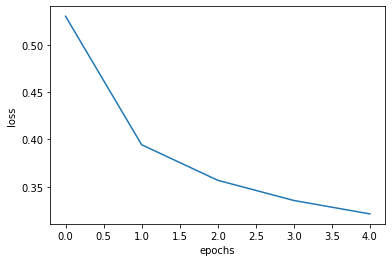

In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

다음으로는 정확도를 출력해보자

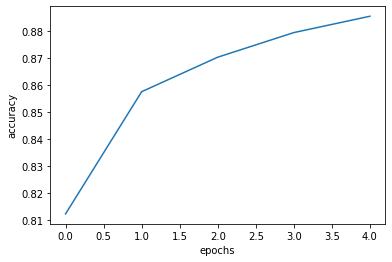

In [7]:
plt.plot(history.history['accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

이번에는 에포크를 20으로 늘려서 모델을 훈련하고 손실 그래프를 그려보자.

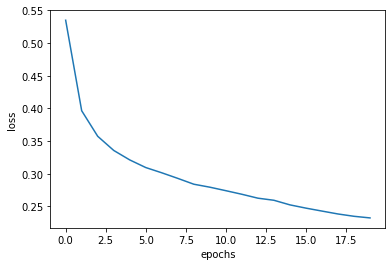

In [8]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0)

plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

이렇게만 보면, 에포크가 늘어날 수록 손실이 줄어드는 이상적인 모델 같다.

근데 과연 정말로 좋은 모델이라고 할 수 있을까?

# 검증 손실

4장에서 확률적 경사 하강법을 사용했을 때 과대/과소적합과 에포크 사이의 관계를 알아보았다.

인공 신경망은 모두 일종의 경사 하강법을 사용하기 때문에 동일한 개념이 적용된다.

에포크에 따른 과대적합과 과소적합을 파악하려면 훈련 세트에 대한 점수뿐만 아니라, 검증 세트에 대한 점수도 필요하다.

따라서 검증 세트에 대한 손실을 사용하여 과대/과소적합을 다뤄보자

에포크마다 검증 손실을 계산하기 위해 fit() 함수에 검증 데이터를 전달할 수 있다.

다음처럼 validation_data 매개변수에 검증에 사용할 입력과 타깃값을 튜플로 만들어 전달하면 된다.

In [9]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data = (val_scaled, val_target))

다음으로 history 딕셔너리에 어떤 값이 들어 있는지 키를 확인해보자.

In [10]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


이제 과대/과소적합 문제를 조사하기 위해 훈련 손실과 검증 손실을 한 그래프에 그려보자.

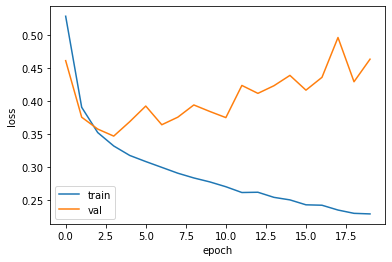

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

여기서는 대략 7번째 에포크에서 가장 적은 손실을 찍고 다시 상승한다.

훈련 손실은 꾸준히 감소하기 때문에 전형적인 과대적합 모델이 만들어진다.

따라서, 검증 손실이 상승하는 시점을 가능한 뒤로 늦추면, 검증 세트에 대한 손실이 줄어들 뿐만 아니라, 검증 세트에 대한 정확도도 증가할 것이다.


---


과대적합을 막기 위해 규제를 적용해보자
- 3장에서 배웠던 규제 대신, 신경망에 특화된 규제 방법은 다음 섹션에서 알아보고,
- 여기서는 옵티마이저를 조정하여 과대적합을 완화시킬 수 있을지 알아보자.

기본 RMSprop은 많은 문제에서 잘 동작한다. 만약 다른 옵티마이저를 테스트해 본다면 Adam이 좋은 선택이다.

Adam 옵티마이저를 적용해 보고 훈련 손실과 검증 손실을 다시 그려보자.

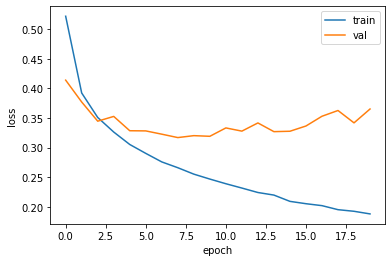

In [12]:
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data = (val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

과대 적합이 훨씬 완화되었다.

검증 손실에는 여전히 요동이 남아 있지만, 10~12 번째 에포크까지 전반적인 감소 추세가 이어진다.
- --> 이 데이터셋에는 Adam 옵티마이저가 잘 맞는다는 것

더 나은 손실 곡선을 얻으려면 학습률을 조정하여 다시 시도해 볼 수도 있다.

다음 섹션에서는 신경망에서 사용하는 대표적인 규제 방법을 알아보자.

# 드롭아웃

드롭아웃(dropout): 훈련 과정에서 층에 있는 일부 뉴런을 랜덤하게 꺼서(출력을 0으로 만들어) 과대적합을 막는다.
- 얼마나 많은 뉴런을 드롭할지는 우리가 정해야 할 또 다른 하이퍼파라미터
- 왜 과대적합을 막는가?
    - 특정 뉴런에 과대하게 의존하는 것을 줄일 수 있고, 모든 입력에 대해 주의를 기울여야 한다.
    - 일부 뉴런의 출력이 없을 수 있다는 것을 감안하면, 더 안정적인 예측을 만들 수 있다.
    - 또한, 드롭아웃을 적용해 서로 다른 훈련과정을 만드는 것은, 마치 여러 신경망을 앙상블하는 것 처럼 상상할 수 있다.
        - 앙상블은 과대적합을 막아주는 아주 좋은 기법이다.

---

케라스에서는 keras.layers 패키지 아래 Dropout 클래스를 제공한다.
- 어떤 층의 뒤에 드롭아웃을 두어, 그 층의 출력을 랜덤하게 0으로 만든다.
- 드롭아웃이 층처럼 사용되지만, 훈련되는 모델 파라미터는 없다.

앞서 정의한 model_fn() 함수에 드롭아웃 객체를 전달하여 층을 추가해보자.
- 여기서는 30% 정도를 드롭아웃한다.
- 드롭아웃 하지 않는 뉴런의 출력은 1/(1-r) 만큼 증가시켜, 출력의 총합이 같도록 한다.

이후에는 summary() 함수를 이용해 층이 잘 추가되었는지 확인해보자.

In [13]:
model = model_fn(keras.layers.Dropout(0.3))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


이제 훈련 손실과 검증 손실의 그래프를 그려 비교해보자

물론, 훈련이 끝난 후에 평가나 예측을 하려면 드롭아웃을 적용하지 말아야 한다.
    - 똑똑하게도 케라스는 모델을 평가와 예측에 사용할 때는, 자동으로 드롭아웃을 적용하지 않는다. 굿

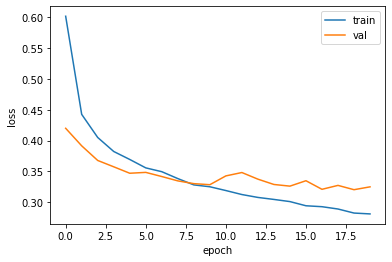

In [14]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data = (val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

과대적합이 확실히 줄었다.

이 모델은 20번의 에포크 동안 훈련했기 때문에 결국 다소 과대적합 되었으므로, 이후에는 10 에포크로 줄여서 다시 훈련해보자.

# 모델 저장과 복원

나중에 훈련한 모델이 필요한 경우를 위하여, 파일로서 저장하는 것도 배워보자.

우선 모델을 만들자.

In [15]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=10, verbose=0, # epochs 10으로 줄임
                    validation_data = (val_scaled, val_target))

케라스 모델은 훈련된 모델의 파라미터를 저장하는 save_weights() 함수를 제공한다.

기본적으로 이 함수는 텐서플로의 체크포인트 포맷으로 저장하지만, 파일의 확장자가 '.h5'인 경우, HDF5 포맷으로 저장한다.

In [16]:
model.save_weights('model-weights.h5')

또한 모델 구조와 모델 파라미터를 함께 저장하는 save() 함수도 제공한다.

기본적으로 이 함수는 텐서플로의 SavedModel 포맷으로 저장하지만, 파일의 확장자가 '.h5'인 경우, HDF5 포맷으로 저장한다.

In [17]:
model.save('model-whole.h5')

디렉토리를 살펴보면 파일이 잘 저장된 것을 볼 수 있다.

이제 두 가지 실험을 해보자
1. 훈련 하지 않은 새로운 모델에 'model-weights.h5'에서 모델 파라미터 읽어오기
2. 아예 'model-whole.h5'에서 새로운 모델을 만들어 바로 사용기

첫 번째 부터 해보자.

In [18]:
model = model_fn(keras.layers.Dropout(0.3))
model.load_weights('model-weights.h5')
# load_weights()를 사용하려면, save_weights()로 저장했던 모델과 정확히 같은 구조를 가져야 한다.

이제 검증 정확도를 확인해보자.

predict() 함수는 사이킷런과 달리 샘플마다 10개의 클래스에 대한 확률을 반환한다.
- 이진 분류 문제라면 양성 클래스에 대한 확률 하나만 반환한다.
- 패션 MNIST 데이터셋에서 덜어낸 검증 세트의 샘플 개수는 12000개이기 때문에, predict() 함수는 (12000, 10) 크기의 배열을 반환한다.
- 따라서 10개 확률 중에 가장 큰 값의 인덱스를 골라 타깃 라벨과 비교하여 정확도를 계산해보자.
    - evaluate() 를 사용하지 않는 이유: 손실을 계산하기 위해 반드시 compile() 을 사용해야 하는데, 여기서는 새로운 데이터에 대한 정확도만 계산하면 되는 상황

argmax(): 배열에서 가장 큰 값의 인덱스를 반환
    - axis=-1: 배열의 마지막 차원을 따라 최댓값을 고른다.
        - predict()의 결과가 2차원 배열을 반환하므로, 2차원(열)을 따라 각 행의 최댓값의 인덱스를 선택한다.
        - axis=0 이면, 1차원(행)을 따라 각 열의 최댓값의 인덱스를 반환한다.

그 다음으로 argmax()로 고른 val_labels와 val_target을 비교하여, 같으면 1, 다르면 0을 평균하여 정확도를 계산한다.

In [20]:
import numpy as np

val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == val_target))

0.8835833333333334


다음으로는 모델 전체를 읽은 다음 검증 세트의 정확도를 출력해보자.

여기서는 load_model() 함수를 사용한다.
- 이렇게 하면 모델 구조와 옵티마이저 상태까지 모두 복원하기 때문에, evaluate() 함수를 사용할 수 있다.

In [21]:
model = keras.models.load_model('model-whole.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3311 - accuracy: 0.8836


[0.3310539126396179, 0.8835833072662354]

같은 모델을 저장하고 다시 불러들였기 때문에 동일한 정확도를 얻었다.

근데, 이 과정을 생각해보면,
- n번 에포크 훈련하여 검증 점수가 상승하는 지점을 찾음
- 모델을 과대적합되지 않는 에포크만큼 다시 훈련함

--> 모델을 두 번씩 훈련하지 않고 한 번에 끝낼 수 없을까?

# 콜백

콜백(callback): 훈련 과정 중에 어떤 작업을 수행할 수 있게 하는 객체
- fit() 함수의 callback 매개변수에 리스트로 전달하여 사용한다.
- ModelCheckpoint 콜백은 기본적으로 에포크마다 모델을 저장한다.
    - save_best_only=True 로 지정하여, 가장 낮은 검증 점수를 만드는 모델을 저장할 수 있다.
    - monitor: 모니터링할 지표를 지정 (default: 'val_loss')
    - save_weights_only: 모델의 가중치와 절편만 저장 (default: False)

In [24]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)

model.fit(train_scaled, train_target, epochs=20, verbose=0,
          validation_data = (val_scaled, val_target),
          callbacks=[checkpoint_cb])

이렇게 저장한 'best-model.h5'를 로드하여 다시 예측을 수행해보자.

In [23]:
model = keras.models.load_model('best-model.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 1ms/step - loss: 0.3281 - accuracy: 0.8797


[0.32814154028892517, 0.8796666860580444]

역시 best이다.

하지만 여전히 20회 훈련을 하는데, 사실 검증 점수가 상승하기 시작하면 훈련을 계속할 필요가 없다.
- 이 때 훈련을 중지하면 컴퓨터 자원과 시간을 아낄 수 있다.
- --> 조기 종료 (early stopping): 훈련 에포크 횟수를 제한하는 역할이지만, 모델이 과대적합되는 것을 막아 주기 때문에, 규제 방법 중 하나로 생각할 수도 있다.

EarlyStopping 콜백은 조기 종료를 위한 콜백이다.
- patience: n번 연속으로 검증 점수가 향상되지 않으면 훈련을 중지
- restore_best_weights: True로 지정하면 가장 낮은 검증 손실을 낸 모델 파라미터로 되돌린다.
- monitor: 모니터링할 지표를 지정 (default: 'val_loss')

EarlyStopping과 ModelCheckpoint 콜백을 함께 사용하면
- 가장 낮은 검증 손실의 모델을 파일에 저장하고
- 검증 손실이 다시 상승할 때 훈련을 중지한다.
- 또한, 훈련을 중지한 다음 현재 모델의 파라미터를 최상의 파라미터로 되돌린다.

In [25]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20, verbose=0,
                    validation_data = (val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

몇 번째 에포크에서 훈련이 중지되었는지, early_stopping_cb 객체의 stopped_epoch 속성에서 확인해보자.

In [26]:
print(early_stopping_cb.stopped_epoch)

13


14번째 에포크에서 훈련이 중지되었다. patience가 2이기 때문에, 최상의 모델은 12번째 에포크일 것이다.

훈련 손실과 검증 손실을 출력해서 확인해보자.

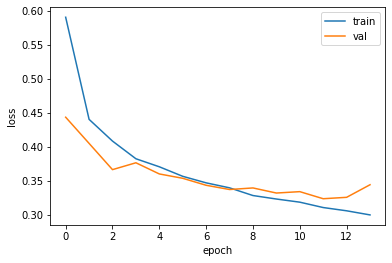

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

확인!

마지막으로 조기 종료로 얻은 모델을 사용해 검증 세트에 대한 성능을 확인해 보자.

In [28]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3234 - accuracy: 0.8831


[0.3234098255634308, 0.8830833435058594]